In [1]:
#=
Data:  Yℓ = Cθℓ + ℘ (dCθωℓ_dω) * ω + nℓ, where Cθℓ is LCDM and dCθωℓ_dω are the linearized exotic model
       and ℘ projects out the LCDM fluxtuations. ω ∼ N(0, σ2 I)

Model: Yℓ = Cθℓ + X * β + nℓ the columns of X are from the top LDA modes 
	from S_P/(κ S_ + N), S_P =  dCθωℓ_dω * dCθωℓ_dωᵀ. the prior on β is non-informative and looks like
	Put g-prior on β ∼ N(0, g * (Xᵀ(N⁻)X)⁻) with π(g) ∝ ?, which is independent of π(θ). 
	(.... maybe β ∼ N(0, g * (Xᵀ(Cθℓ + N)⁻X))⁻) is better instead). 
	Use Metropolis Hasitings to sample from the posterior on (β, θ).

Notes:
	We use a subjective prior on ω for constructing the LDA design matrix X, 
	but use a non-informative g-prior the posterior on β. 
	I think this solves the problem that a non-informative prior for ω
	will not generate meaningful LDA modes (since a non-informative prior on ω make Cθωℓ behave like white noise)

	kill -9 -1 ...this kills all procs from a given user

	run with  include("scripts/MetropolisForLDA.jl") 

ToDo:
	- eigs(Symmetric(...)) in place of custom_real_eigs
	- start a new git repo, move source code to src, clean up src, make a ipython notebook
=#

In [2]:
using LDAforCMB
using Optim, Distributions, PyCall, PyPlot 
@pyimport seaborn as sns
@pyimport pandas as pd

# --- set the seed
if false # < --- set to false if you want to use a specific seed
	seedstart = rand(UInt64)
else
	# seedstart = 0x182d22f551268f03 	# max scan pte ≈ 
								   		# 𝛘2       pte ≈ 
								   		# β model  pte ≈ 
	#seedstart = 0xc84e63463536b6fe 	# max scan pte ≈ 
								   		# 𝛘2       pte ≈ 
								   		# β model  pte ≈ 
	seedstart = 0x6d800cba0725d111 	# max scan pte ≈ 
 										# 𝛘2       pte ≈ 
 										# β model  pte ≈ 
end
srand(seedstart);

In [3]:
const mcmc_runs     = 5_000
const mcmc_thin     = 5
const mcmc_burn     = 500

const exotic_on    = true
const exotic_scale = 0.4
const n_basis      = 5 	       # <----- number of columns of X in Bayesian chain
const kappa        = 1_000.0   # <---- factor to force LDA modes to be approx orthogonal to S_L

const lmax         = 2400
const indexrange   = collect(10:lmax)            # <----  the files start at ell = 0
const ell          = collect(0:5000)[indexrange]
const n            = length(indexrange)
const fwhm         = 20 			              # <---- radius of ell smoothing of dCl_dPa
const lcdm_fid_par = [0.0825,  0.125,   3.218,  0.010413, 0.97,  0.022]
const lcdm_names = [:tau,  :omch2,  :logA, :theta  , :ns,  :ombh2]
const cl_fid       = trans_to_pico(lcdm_fid_par)[indexrange];

pypico.datafiles.98615da6b9bdec783e9b232dd90da683:278: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [4]:
# ----- make noise_var
function var_of_cls(ell, cls)
	Nell = 0.00015048 * exp( ell.^2 * 7.69112e-7 ) .* (ell.^2) / 2 / pi
	fsky = 0.3
	2 * ((cls .+ Nell).^2 ./ (2*ell .+ 1)) / fsky # the` broadcasts Nell
end



# get the cov matrix for lcdm
const lcdm_cov = let
		covpath = joinpath(LDAforCMB.pathtosrc, "chain_data/proposal.covmat")
		propcov = map(Float64, readdlm(covpath))
		propcov_names = 
			covpath |> 
			open |> 
			readline |> 
			split |> 
			x->convert(Array{ASCIIString},x) |>
			x->x[2:end]

		lcdmi = [1, 9, 12, 14, 15, 16]
		propcov[lcdmi,lcdmi]  # <-- gives the corresponding cov mat
	end
const lcdm_chol = chol(lcdm_cov, Val{:L})





# -----  make S_L, N (LCDM signal cov and noise cov matrix)
const S_L, N, dCl_dtheta =  let
	dx = diagm(1e-6 * ones(6))
	dCl_dtheta = Array(Float64, length(ell), 6)
	for k=1:6
		dCl_dtheta[:,k] =  (trans_to_pico(lcdm_fid_par + dx[:,k]) - trans_to_pico(lcdm_fid_par))[indexrange] /  dx[k,k]
	end 
	S_L  = dCl_dtheta  * dCl_dtheta.' 
	N    = diagm(var_of_cls(ell,cl_fid))

	S_L, N, dCl_dtheta
end



# -----  make S_P, X (exotic cov matrix, LDA exotic design)
const S_P, S_Pforsim, X, Xfull, eigfull = let
	responses_Pa       = readcsv(joinpath(LDAforCMB.pathtosrc, "covariances/responses.csv"))[indexrange, 30:(end-60)]
	responses_transfer = transpose(readcsv(joinpath(LDAforCMB.pathtosrc, "covariances/responses_transfer.csv")))[indexrange, :] 
	lcdm_fid           = readcsv(joinpath(LDAforCMB.pathtosrc, "covariances/lcdm_fid.csv"))[indexrange]
	
	dCl_dT   = responses_transfer .- lcdm_fid
	dCl_dPa  = responses_Pa .- lcdm_fid  
	smoothmat = zeros(n, n)
	for k in -fwhm:fwhm
		smoothmat += diagm(ones(n-abs(k)),k)
	end
	smoothmat = smoothmat ./ sum(smoothmat, 2)
	dCl_dPa   = smoothmat * dCl_dPa 

	
	## !!!!! here I take out the LCDM looking modes
	## dCl_dPa -=  dCl_dtheta * ((dCl_dtheta.' * dCl_dtheta) \ (dCl_dtheta.' * dCl_dPa)) 
	
	# ---- generate the LDA vectors

	
	### option:    random raw modes
	# XX   =  dCl_dPa[:, rand(1:size(dCl_dPa,2), n_ω)]]
	### option:    random raw modes with LCDM projected out
	# XX  =  dCl_dPa[:,rand(1:size(dCl_dPa,2), n_ω)]
	# XX =  XX - dCl_dtheta * ((dCl_dtheta.' * dCl_dtheta) \ (dCl_dtheta.' * XX)) 
	### option:    LDA modes (more than used for estimation)
	# _, XX = custom_real_eigs((N + kappa * S_L) \ dCl_dPa * dCl_dPa.' , n_ω)
	### option:     PCA then project out dCl_dtheta
	#_, XX = custom_real_eigs(dCl_dPa * dCl_dPa.', n_ω)
	#XX =  XX - dCl_dtheta * ((dCl_dtheta.' * dCl_dtheta) \ (dCl_dtheta.' * XX)) 
	XX   =  dCl_dPa
	S_P  =  XX * XX.'
	eigfull, Xfull = custom_real_eigs((N + kappa * S_L) \ S_P, n_basis + 50)


	# ---- This is used for the simulations (and is slightly smoother)
	# ---- The hope is that the LDA will automatically look for smoother detectable modes even when
	# ---- generated from a non-smooth prior.
	#
	# ---- This also has the benefit of generating simulations which have a large detectable smooth fluctuation 
	# ---- without large visible spikes at low ell.
	nm = size(dCl_dPa, 2) 
	Σ = Float64[exp(-abs(i-j)^1.9/25) for i=1:nm, j=1:nm]
	#plot(chol(Σ, Val{:L})*randn(111))
	XXforsim = XX * chol(Σ, Val{:L})  # correlates the primordial top-hat modes
	S_Pforsim = XXforsim * XXforsim.'

	
	S_P, S_Pforsim, Xfull[:,1:n_basis], Xfull, eigfull
end



# ---- set the prior and a proposal distribution
# const β_prior_RV    = MvTDist(20.0, zeros(n_basis), 10*inv(X.' * ((S_L + N) \ X)))
const β_prior_RV    = MultivariateNormal(zeros(n_basis), abs2(25)*inv(X.' * (N \ X)))
const lcdm_prior_RV = MultivariateNormal(lcdm_fid_par, abs2(1)*lcdm_cov)


# ------  choose a proposal distribution
const β_proposal_RV    = MultivariateNormal(zeros(n_basis), abs2(0.5) * inv(X.' * (N \ X)) )
const lcdm_proposal_RV = MultivariateNormal(zeros(lcdm_fid_par), abs2(0.5) * lcdm_cov)
prop_β(β_curr)	       = rand(β_proposal_RV) + β_curr
prop_lcdm(lcdm_curr)   = rand(lcdm_proposal_RV) + lcdm_curr


# ------ loglikelihood
function loglike(lcdm_pars, β, cl_obs)
	clTT = try trans_to_pico(lcdm_pars)[indexrange] catch zeros(n) end 
	clTT += exotic_on ? (X * β) : zeros(n)
	noise_var_new =  var_of_cls(ell, clTT)
	logl = 0.0	
	for k in 1:length(indexrange)
		logl += -0.5 * ((cl_obs[k] - clTT[k])^2) / noise_var_new[k]
	end
	logl += logpdf(lcdm_prior_RV, lcdm_pars)
	logl += exotic_on ? logpdf(β_prior_RV, β) : zero(Float64) 
	logl 
end


# find mle now make an mle for LCDM parameters which uses LDA to avoid exotic directions
let
	# topXfullmodes is the number of modes used for the max_scan statistic
	const topXfullmodes = findfirst(cumsum(eigfull) .> (.99 * sum(eigfull)) )
	#const topXfullmodes = findfirst(eigfull .< 0.1maximum(eigfull))
	const v = nullspace(Xfull[:,1:topXfullmodes].')
	# ------ loglikelihood
	function loglike_maxscan(lcdm_pars, cl_obs)
		clTT          = try trans_to_pico(lcdm_pars)[indexrange] catch zeros(n) end 
		noise_var_new =  var_of_cls(ell, clTT)	
		vcldiff       = v.' * (clTT - cl_obs)
		Nnew          = diagm(var_of_cls(ell,clTT))
		vNv           = v.' * (Nnew * v)	
		L             = chol(vNv, Val{:L})
		logl          = -0.5 * sumabs2(L \ vcldiff)	
		logl          += logpdf(lcdm_prior_RV, lcdm_pars)
		logl 
	end
	global findmle
	function findmle(cl_obs)
		minimize_me(x) = -loglike_maxscan(lcdm_chol * x, cl_obs)
		initalx  = lcdm_chol \ lcdm_fid_par
		optout   = Optim.optimize(minimize_me, initalx)
		x_mle    = optout.minimum
		lcdm_mle = lcdm_chol * x_mle
		return lcdm_mle
	end
end

function mcmc_chain(cl_obs, numruns::Int64, thin::Int64, burn::Int64, lcdm_start = lcdm_fid_par, β_start = zeros(n_basis))
	lcdmmat      = Array(Float64, 6, numruns)
	βmat         = Array(Float64, n_basis, numruns)
	lcdmmat[:,1] = copy(lcdm_start)
	βmat[:,1] 	 = copy(β_start)
	curr_ll		 = loglike(lcdm_start, β_start, cl_obs)
	for j = 2:numruns
		lcdm_prop = prop_lcdm(lcdmmat[:, j-1])
		β_prop    = prop_β(βmat[:, j-1])
		prop_ll   = loglike(lcdm_prop, β_prop, cl_obs)
		prob_accept = min(1.0, exp(prop_ll - curr_ll)) 
		if j % 250 == 1
			@show prob_accept
		end
		if rand() < prob_accept
			lcdmmat[:,j] = copy(lcdm_prop)
			βmat[:,j]	 = copy(β_prop)
			curr_ll		 = prop_ll
		else 
			lcdmmat[:,j] = copy(lcdmmat[:, j-1])
			βmat[:,j]	 = copy(βmat[:, j-1])
		end
	end
	return lcdmmat[:,burn:thin:end], βmat[:,burn:thin:end]
end 


mcmc_chain (generic function with 3 methods)

/Users/ethananderes/Software/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1015: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/ethananderes/Software/anaconda/lib/python2.7/site-packages/matplotlib/axis.py:1025: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


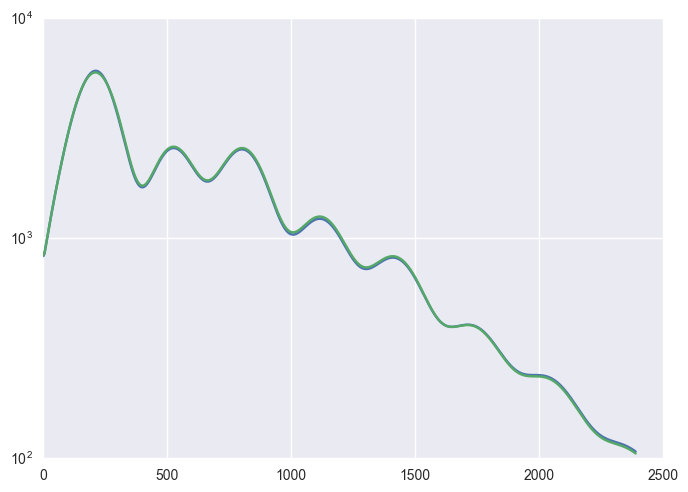

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32d728a90>

In [5]:

# ------ make data --- nonlinear
function gendata(scalefactor)
	cl_lcdm_pars = rand(MultivariateNormal(lcdm_fid_par, abs2(0.25)*lcdm_cov)) 
	cl_lcdm      = trans_to_pico(cl_lcdm_pars)[indexrange]
	dp           = samp_cov(S_Pforsim)  # <---- exotic fluctuation
	cl_exotic    = cl_lcdm 
	cl_exotic   += exotic_on ? (dp .* scalefactor) : zeros(cl_exotic)
	cl_obs    	 = cl_exotic + √(var_of_cls(ell, cl_exotic)) .* randn(length(ell))
	cl_obs, cl_exotic, cl_lcdm, cl_lcdm_pars
end

cl_obs, cl_exotic, cl_lcdm, cl_lcdm_pars = gendata(exotic_scale)

semilogy(cl_exotic)
semilogy(cl_lcdm)

In [6]:
#  ----- run the mcmc 
lcdm_mle = findmle(cl_obs)
clmle = trans_to_pico(lcdm_mle)[indexrange]
@time lcdmmat, βmat = mcmc_chain(cl_obs, mcmc_runs, mcmc_thin, mcmc_burn, lcdm_mle)

prob_accept = 0.28863961290959445
prob_accept = 0.007873252701368846
prob_accept = 0.08605225305230782
prob_accept = 0.9734193271737899
prob_accept = 0.1956096057741955
prob_accept = 0.009342542723506188
prob_accept = 0.0055959613321159745
prob_accept = 0.3933988853120626
prob_accept = 0.055841598014356744
prob_accept = 0.6405975809093636
prob_accept = 1.0
prob_accept = 0.7106675005999117
prob_accept = 0.04584948225576438
prob_accept = 0.35251017424780917
prob_accept = 0.007033248928784868
prob_accept = 0.299605146303224
prob_accept = 0.24352904899809208
prob_accept = 0.04478095793551069
prob_accept = 0.25385771028190546
287.

(
6x901 Array{Float64,2}:
 0.064959   0.064959   0.0583875  …  0.0623286  0.0706584  0.0706584
 0.127994   0.127994   0.12679       0.129087   0.129323   0.129323 
 3.2292     3.2292     3.23187       3.25438    3.27545    3.27545  
 0.0104074  0.0104074  0.0104116     0.0104207  0.010419   0.010419 
 0.955845   0.955845   0.951458      0.94836    0.947696   0.947696 
 0.0217873  0.0217873  0.0219434  …  0.0218429  0.021949   0.021949 ,

5x901 Array{Float64,2}:
  165.859    165.859    193.471   …   183.433    256.141    256.141 
  -24.8246   -24.8246    36.7475       48.2371    86.0377    86.0377
   94.3453    94.3453   159.194       296.939    303.639    303.639 
 -254.495   -254.495   -262.363      -240.354   -228.922   -228.922 
  314.695    314.695    377.967       311.219    326.519    326.519 )

784455 seconds (123.87 M allocations: 6.398 GB, 0.42% gc time)


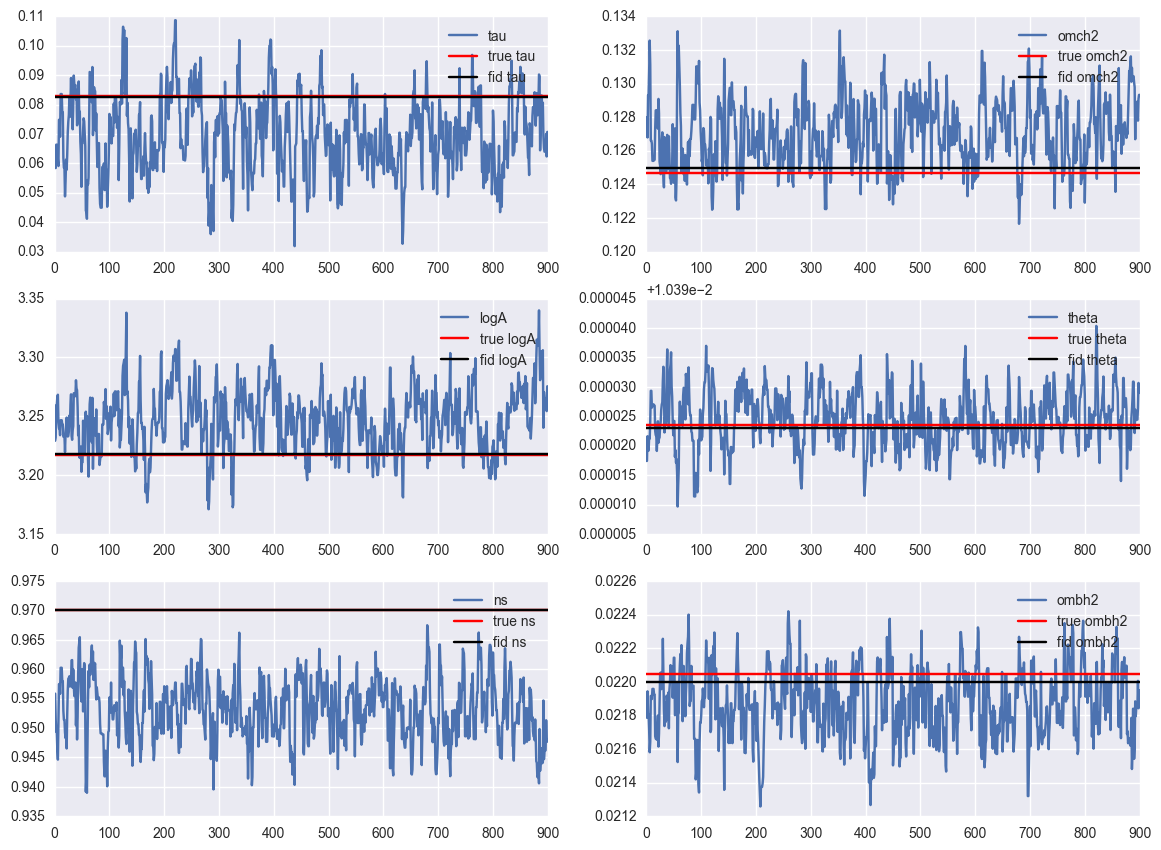

In [7]:
# ----- make some plots of the output

# ----- trace plots for the lcdm parameters
figure(figsize = (14,10))
for cntr = 1:6
	subplot(3,2,cntr)
	plot(lcdmmat[cntr,:].', label="$(lcdm_names[cntr])")
	plot(zeros(lcdmmat[cntr,:].')+cl_lcdm_pars[cntr], color="r", label="true $(lcdm_names[cntr])")
	plot(zeros(lcdmmat[cntr,:].')+lcdm_fid_par[cntr], color="k", label="fid $(lcdm_names[cntr])")

	legend()
end

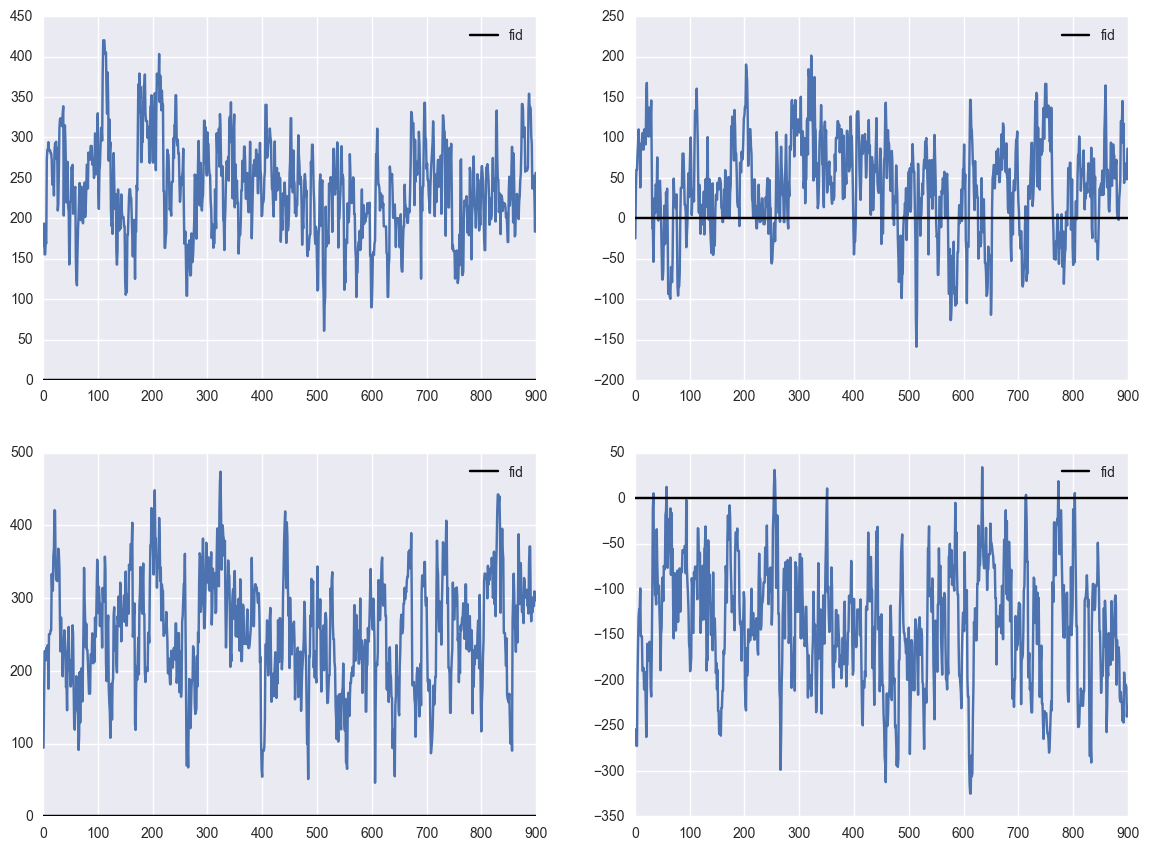

In [8]:
# -----  trace plots for the βs
figure(figsize = (14,10))
for cntr = 1:min(n_basis,4)
	subplot(2,2,cntr)
	plot(βmat[cntr,:].')
	plot(zeros(βmat[cntr,:].'), color="k", label="fid")
	legend()
end

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x34736edd0>)

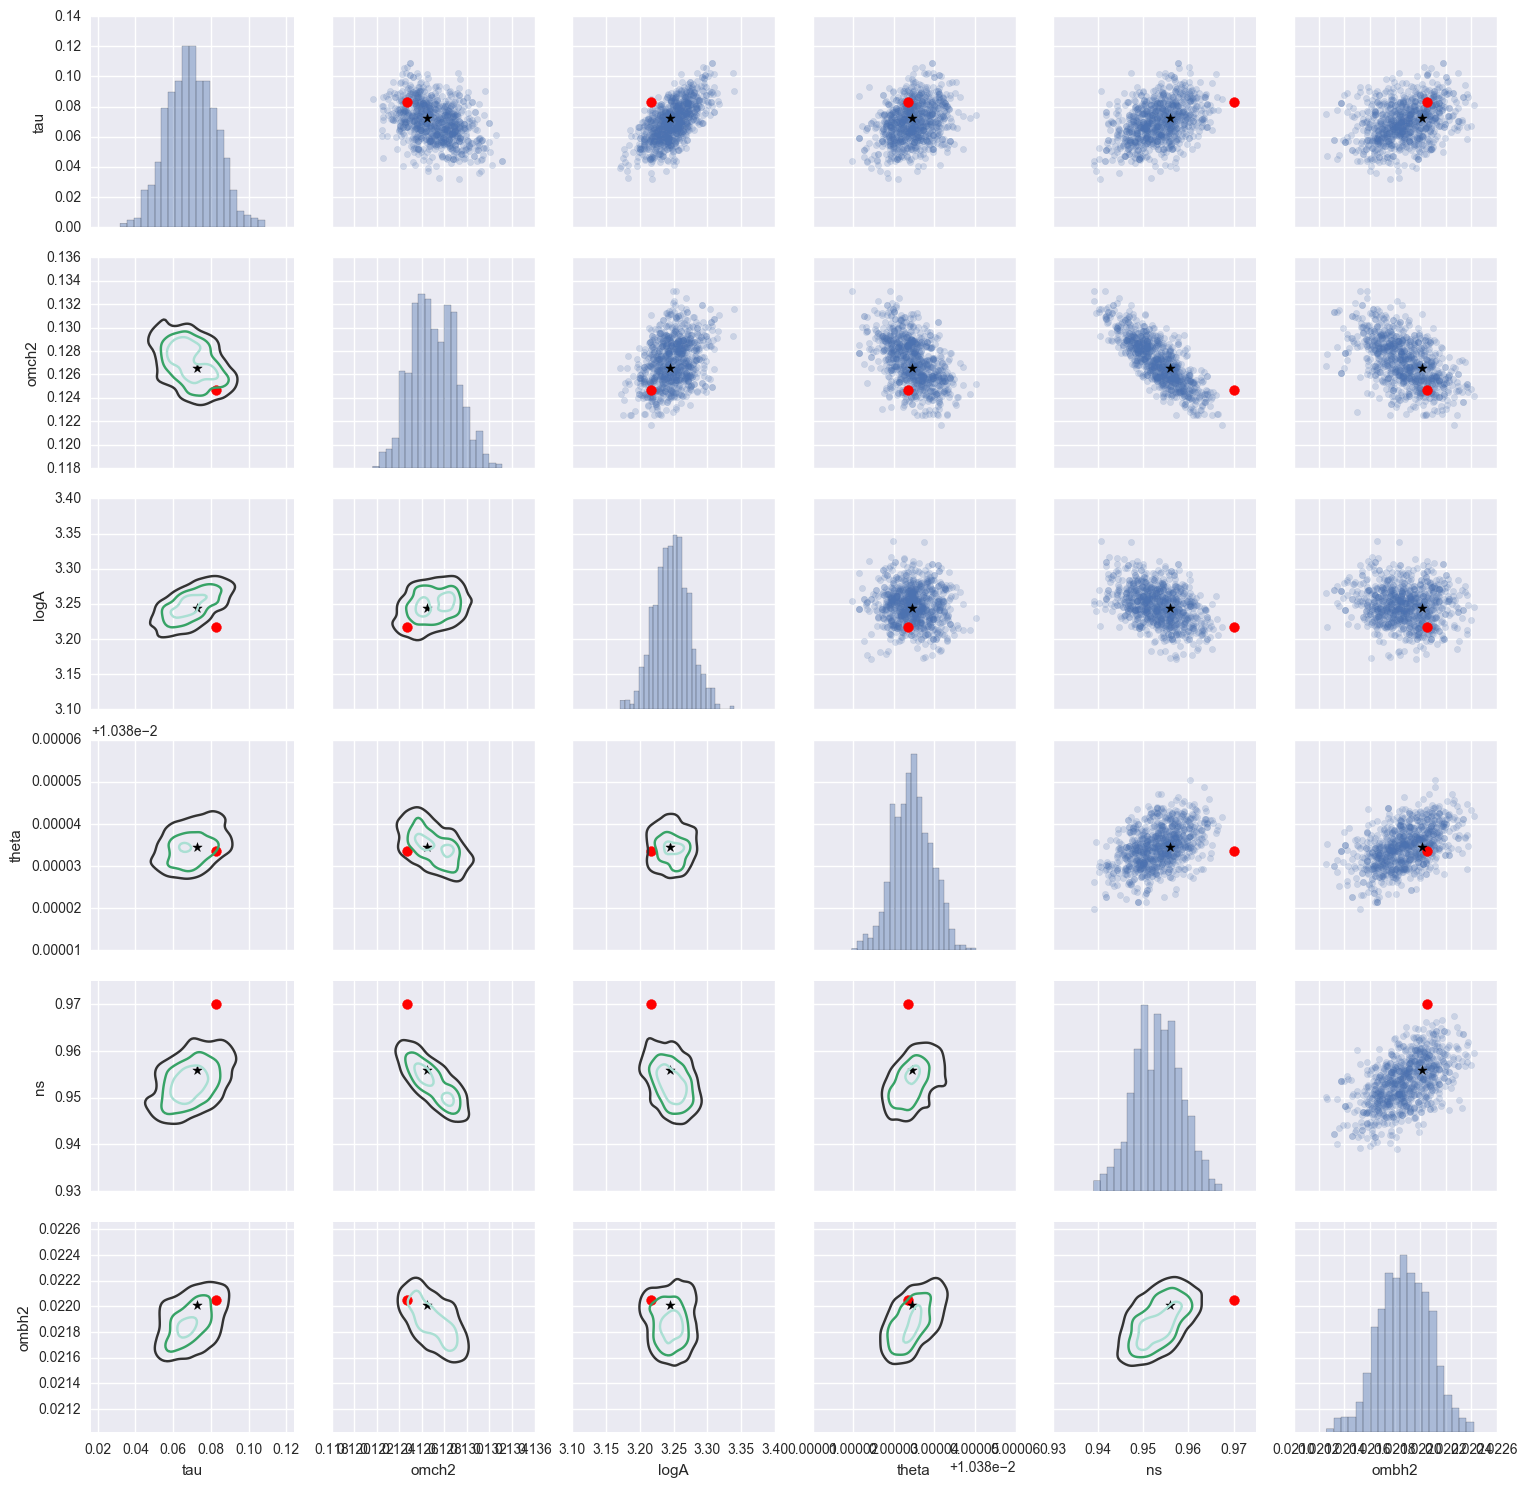

PyObject <seaborn.axisgrid.PairGrid object at 0x34732c890>

In [17]:
# -----  pairplots for the lcdm parameters
figure()
lcdmdf = pd.DataFrame(lcdmmat.', columns=lcdm_names)
g = sns.PairGrid(lcdmdf)
g[:map_diag](sns.distplot, kde=false, rug=false)
g[:map_lower](sns.kdeplot, n_levels = 3)
g[:map_upper](plt[:scatter], alpha = 0.2)
centroids = pd.DataFrame(cl_lcdm_pars.', columns=lcdm_names)
g[:data] = centroids
g[:map_offdiag](plt[:scatter], s=200, marker=".", color="red")
centroids = pd.DataFrame(lcdm_mle.', columns=lcdm_names)
g[:data] = centroids
g[:map_offdiag](plt[:scatter], s=50, marker="*", color="k")

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x338c1da10>)

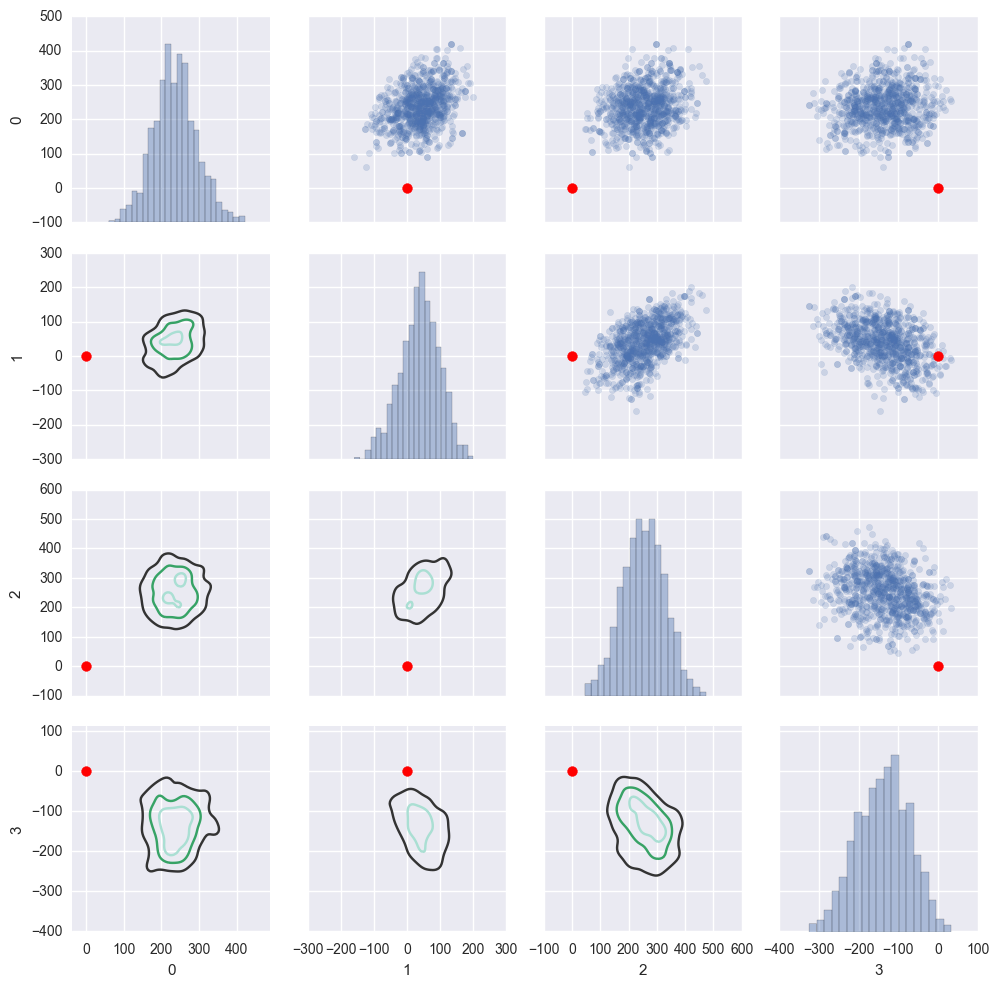

PyObject <seaborn.axisgrid.PairGrid object at 0x3388fac10>

In [18]:
# -----  pairplots for the βs
figure()
βdf = pd.DataFrame(βmat[1:4,:].')
g = sns.PairGrid(βdf)
g[:map_diag](sns.distplot, kde=false, rug=false)
g[:map_lower](sns.kdeplot, n_levels = 3)
g[:map_upper](plt[:scatter], alpha = 0.2)
centroids = pd.DataFrame(zeros(1,n_basis))
g[:data] = centroids
g[:map_offdiag](plt[:scatter], s=200, marker=".", color="red")
# centroids = pd.DataFrame(β_mle.')
# g[:data] = centroids
# g[:map_offdiag](plt[:scatter], s=50, marker="*", color="k")

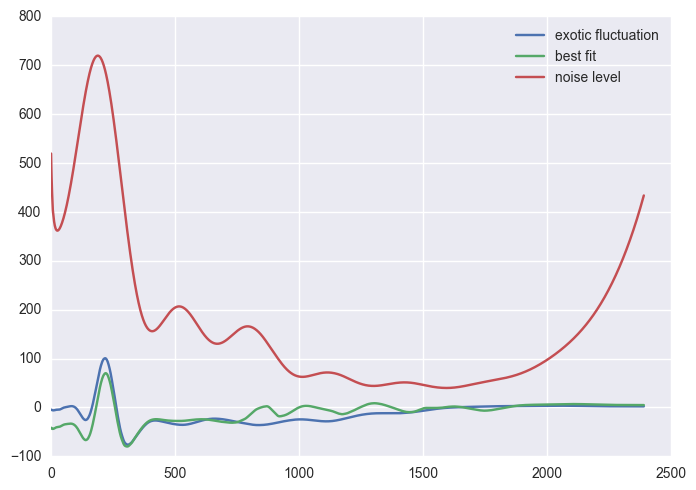

PyObject <matplotlib.legend.Legend object at 0x344721cd0>

In [19]:
#  ----- best fit
figure()
lcdm_fit = vec(mean(lcdmmat,2))
β_fit = vec(mean(βmat,2))
cl_fit = trans_to_pico(lcdm_fit)[indexrange] +  X * β_fit
noise_level = sqrt(var_of_cls(ell, cl_fit))
plot((cl_exotic-cl_lcdm), label = "exotic fluctuation")
plot((cl_exotic-cl_fit),  label = "best fit")
plot(noise_level,  label = "noise level")
#plot(cl_exotic,  label = "true model")
legend()

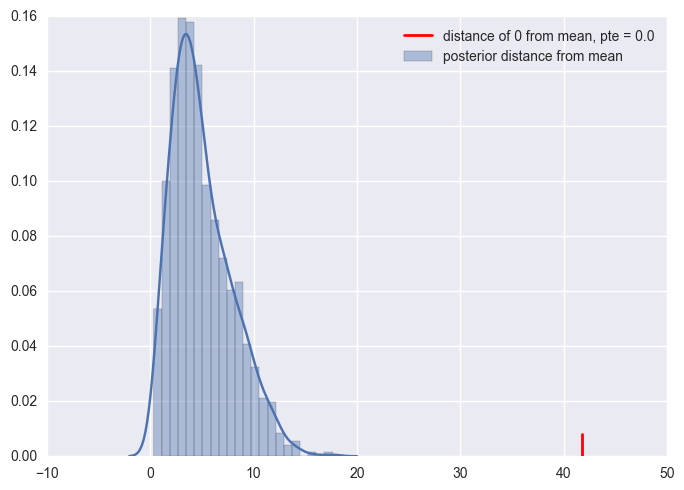

PyObject <matplotlib.legend.Legend object at 0x344c6f450>

In [20]:
# ------ poterior PTE for β
figure()
const βΣ = cov(βmat.')
const βm = vec(mean(βmat,2))
β_functional(β) = (β.-βm).' * (βΣ \  (β.-βm)) 
post_β_functional = mapslices(β_functional, βmat, 1)
pte = sum(post_β_functional .>= β_functional(zeros(βm)))/size(βmat,2)
sns.distplot(post_β_functional, label = "posterior distance from mean")
sns.rugplot(β_functional(zeros(βm)), color = "red", linewidth = 2, label = "distance of 0 from mean, pte = $(round(pte,4))")
legend()

In [21]:
# ---- max scan test:

function sim_maxscanChi2(Xfull, clmle, n_sims)
	sims = zeros(n_sims)
	sims_maxat = zeros(n_sims)
	for k = 1:n_sims
		noisesim = √(var_of_cls(ell, clmle)) .* randn(length(ell))
		sims[k], sims_maxat[k] = maxscanChi2(Xfull, clmle + noisesim, clmle)
	end
	return sims, sims_maxat
end
function sim_redularChi2(Xfull,  clmle, n_sims)
	sims = zeros(n_sims)
	for k = 1:n_sims
		noisesim = √(var_of_cls(ell, clmle)) .* randn(length(ell))
		sims[k] = redularChi2(Xfull, clmle + noisesim, clmle)
	end
	return sims
end


function maxscanChi2(Xfull, cl_obs, clmle)
	Xclmle = Xfull.' * clmle
	Xcl_obs = Xfull.' * cl_obs
	Nmle = diagm(var_of_cls(ell, clmle))
	XNX = Xfull.' * (Nmle * Xfull)
	teststat, maxat = 0.0, 0
	for modes = 1:size(XNX,2)
		tmp = reducdedChi2(Xclmle[1:modes], Xcl_obs[1:modes], XNX[1:modes, 1:modes])
		if tmp >= teststat
			teststat = tmp
			maxat = modes
		end
	end
	return teststat, maxat
end

function redularChi2(Xfull, cl_obs, clmle)
	Xclmle = Xfull.' * clmle
	Xcl_obs = Xfull.' * cl_obs
	Nmle = diagm(var_of_cls(ell, clmle))
	XNX = Xfull.' * (Nmle * Xfull)
	return reducdedChi2(Xclmle, Xcl_obs, XNX)
end

function reducdedChi2(Xclmle, Xcl_obs, XNX) 
	chival =  ((Xcl_obs - Xclmle).' * (XNX \ (Xcl_obs - Xclmle)))[1] 
	# ---- option 1
	chival -= size(XNX,1)
	chival /= √(2*size(XNX,1))
	# ---- option 2
	# chival = chi2_to_normal(chival, size(XNX, 1))
	return chival
end

function chi2_to_normal(x, df) 
	cdfx = logcdf(Chisq(df), x)
	invcdfcdfx = invlogcdf(Normal(0, 1), cdfx)
	return invcdfcdfx
end 

chi2_to_normal (generic function with 1 method)

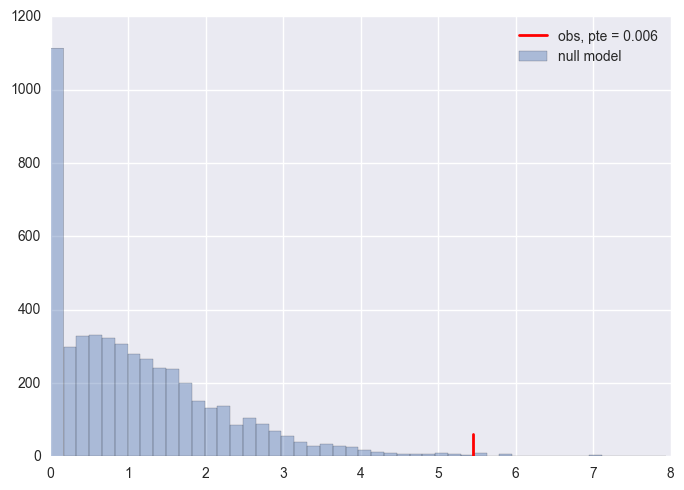

PyObject <matplotlib.legend.Legend object at 0x344ce7290>

In [22]:
number_of_modes_maxing = findfirst(cumsum(eigfull) .> (0.99 * sum(eigfull)) )
# number_of_modes_maxing = findfirst(eigfull .< 0.01maximum(eigfull))
# number_of_modes_maxing = 50
obs_test_stat, obs_maxat = maxscanChi2(Xfull[:,1:number_of_modes_maxing], cl_obs, clmle)
sim_test_stat, sim_maxat = sim_maxscanChi2(Xfull[:,1:number_of_modes_maxing], clmle, 5000)
pte = sum(sim_test_stat .>= obs_test_stat)/length(sim_test_stat)

figure()
sns.distplot(sim_test_stat, kde = false, label = "null model")
sns.rugplot([obs_test_stat], color = "red", linewidth = 2, label = "obs, pte = $(round(pte,4))")
legend()

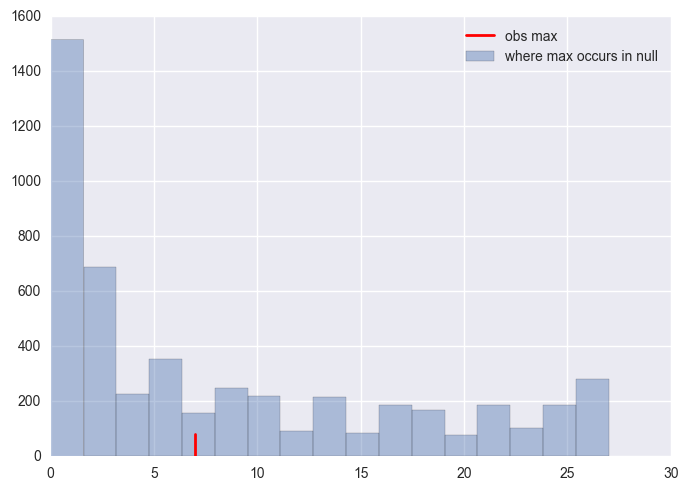

PyObject <matplotlib.legend.Legend object at 0x344cc99d0>

In [23]:
# where the max occured
figure()
sns.distplot(sim_maxat, kde = false, label = "where max occurs in null",kde=false)
sns.rugplot([obs_maxat], color = "red", linewidth = 2, label = "obs max")
legend()

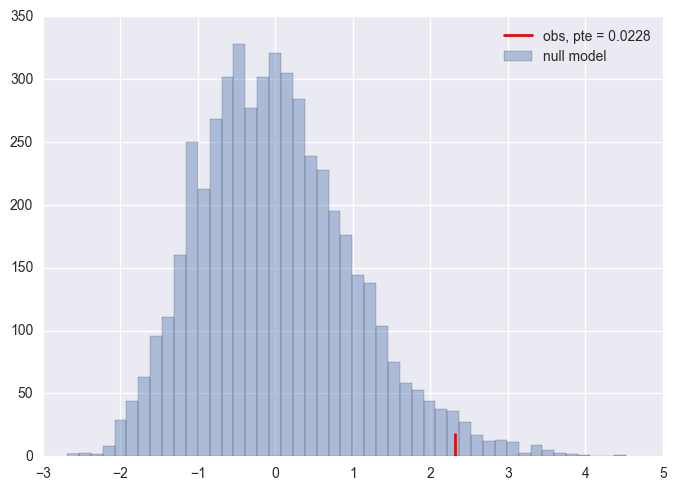

PyObject <matplotlib.legend.Legend object at 0x344a34b50>

In [24]:
#  now for the regular chi2
obs_test_statr = redularChi2(Xfull[:,1:number_of_modes_maxing], cl_obs, clmle)
sim_test_statr = sim_redularChi2(Xfull[:,1:number_of_modes_maxing], clmle, 5000)
pte = sum(sim_test_statr .>= obs_test_statr) / length(sim_test_statr)

figure()
sns.distplot(sim_test_statr, kde = false, label = "null model")
sns.rugplot([obs_test_statr], color = "red", linewidth = 2, label = "obs, pte = $(round(pte,4))")
legend()